## San Diego COVID-19 History and Projections

For the past few weeks, the San Diego Regional Data Library has been scraping the offical COVID statistics from the County of San Diego. The data package is in the [Library's data repository](https://data.sandiegodata.org/dataset/sandiegodata-org-covid19-1-2-0/). Along with other data in the Library's collection, we now have neough observations to produce some estimates of the future growth of cases in the County 


In [1]:
import sys
# Install required packages
!{sys.executable} -mpip -q install matplotlib seaborn statsmodels pandas publicdata metapack

%matplotlib inline

import pandas as pd
import geopandas as gpd
import numpy as np
import metapack as mp
import rowgenerators as rg
import publicdata as pub
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

from sklearn import  linear_model
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.stats import weibull_min, lognorm, logistic, norm
from scipy.optimize import curve_fit
from scipy.special import erf
from sklearn.metrics import r2_score


In [2]:
import metapack as mp
pkg = mp.open_package('http://library.metatab.org/sandiegocounty.gov-covid19-1.1.5.csv')

# Create Dataframes
covid_stats_df = pkg.resource('covid_stats').dataframe()
covid_jurisdiction_df = pkg.resource('covid_jurisdiction').dataframe()
covid_jurisdiction_geo_gdf = pkg.resource('covid_jurisdiction_geo').geoframe()
covid_zip_df = pkg.resource('covid_zip').dataframe()
covid_zip_geo_gdf = pkg.resource('covid_zip_geo').geoframe()


In [3]:
df = covid_stats_df[['date','tests','positives','hospitalized','icu','deaths']].sort_values('date')
df['date'] = pd.to_datetime(df.date)

df.columns = ['date', 'tests', 'cases', 'hosp','icu', 'deaths']
df['date'] = pd.to_datetime(df.date)
start_date = df.iloc[0].date
start_cases = df.iloc[0].cases
df['day'] = (df.date - start_date).dt.days

df['new_cases'] = df.cases.diff()
df['cases_rate'] = df.cases.diff()/ df.cases.shift(1)
df['cases_smooth'] = lowess(df.cases, df.day)[:,1]
df['cases_smooth_rate'] = df.cases_smooth.diff()/df.cases_smooth.shift(1)

df['new_hosp'] = df.hosp.diff()
df['hosp_rate'] = df.hosp.diff()/ df.hosp.shift(1)
df['hosp_smooth'] = lowess(df.hosp.fillna(0), df.day)[:,1]
df['hosp_smooth_rate'] = df.hosp.diff()/df.hosp_smooth.shift(1)

df['new_deaths'] = df.deaths.diff()
df['deaths_rate'] = df.deaths.diff()/ df.deaths.shift(1)
df['deaths_smooth'] = lowess(df.deaths.fillna(0), df.day)[:,1]
df['deaths_smooth_rate'] = df.deaths_smooth.diff()/df.deaths_smooth.shift(1)

#df['double_days'] = np.log(2)/np.log(1+df.cases_smooth_rate)


df.tail()

,date,tests,cases,hosp,icu,deaths,day,new_cases,cases_rate,cases_smooth,cases_smooth_rate,new_hosp,hosp_rate,hosp_smooth,hosp_smooth_rate,new_deaths,deaths_rate,deaths_smooth,deaths_smooth_rate
45,2020-04-21 08:00:00,36464.0,2491,611.0,206.0,96.0,45,57.0,0.023418,2582.922755,0.031392,19.0,0.032095,617.719031,0.031846,9.0,0.103448,91.578545,0.048000
46,2020-04-22 08:00:00,38689.0,2643,634.0,213.0,100.0,46,152.0,0.061020,2661.562698,0.030446,23.0,0.037643,638.788922,0.037234,4.0,0.041667,95.791942,0.046009
47,2020-04-23 08:00:00,41811.0,2826,658.0,218.0,102.0,47,183.0,0.069240,2740.292957,0.029580,24.0,0.037855,659.826620,0.037571,2.0,0.020000,100.025063,0.044191
48,2020-04-24 08:00:00,43638.0,2943,683.0,225.0,111.0,48,117.0,0.041401,2819.173311,0.028785,25.0,0.037994,680.834351,0.037889,9.0,0.088235,104.277868,0.042517
49,2020-04-25 08:00:00,44935.0,3043,696.0,227.0,111.0,49,100.0,0.033979,2898.245168,0.028048,13.0,0.019034,701.814524,0.019094,0.0,0.000000,108.549749,0.040966


In [4]:
def func_norm(x, loc, scale, a):
    return a*norm.pdf(x,loc, scale)
func_norm.popt =  (22, 10, 3659)

def func_logpdf(x, loc, scale, a):
    return a*logistic.pdf(x,loc, scale)
func_logpdf.popt =  (22, 10, 3659)

def func_logistic(x, loc, scale, a): # popt = (14,4, 800)
    return a*logistic.cdf(x, loc, scale)
func_logistic.popt =  (14,4, 800)


def func_erf(x, loc, scale, a, b):
    return a*erf( (x-loc) / scale ) + b
func_erf.popt = (50,20,3000,3000)

def func_gomp(x, a, b, c):
    return a * np.exp(-b * np.exp(-c * x))
func_gomp.popt = (1000,10,.1)




[3.68701289e+03 7.73770247e+00 6.86398497e-02]


/Users/eric/opt/anaconda3/envs/data/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


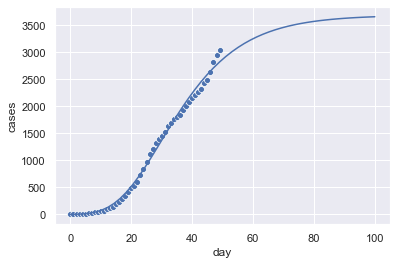

In [5]:
t = df.copy() 


popt, pcov = curve_fit(func_gomp, t.day, t.cases, absolute_sigma = True)
print(popt)

sns.scatterplot(x=t.day, y=t.cases)

x=np.linspace(0,100)


sns.lineplot(x=x, y=func_gomp(x, *popt))

    

Mean=34.0, R^2=0.3483105917404371
Mean=32.0, R^2=0.5144073229963457
Mean=4138.0, R^2=0.3421291573075955


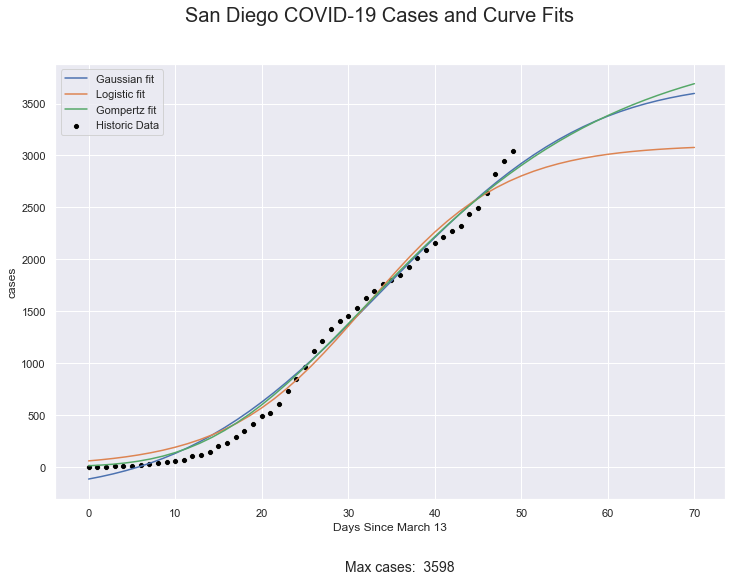

In [6]:



def ln_fit(df, fig, ax, col_name, use_smooth=True, pred_days = 70, text=True, fit_func = func_erf, label='', normalize=False):


    fit_col = col_name+'_smooth' if use_smooth else col_name
    
    t = df.dropna(subset=['day',fit_col])
    
    popt, pcov = curve_fit(fit_func, t.day, t[fit_col], p0=fit_func.popt, absolute_sigma = True)
   
    x=np.linspace(0,pred_days)
    proj = fit_func(x, *popt)
    
    sns.lineplot(x=x, y=proj/(proj.max() if normalize else 1), ax=ax, label=label)
    
    perr = np.sqrt(np.diag(pcov))
    
    max_cases = np.max(proj)
    
    if text: 
        plt.gcf().text(.46,-0,f"Max {col_name}: {max_cases:5.0f}", fontsize=14) 
    
    return popt, perr, x, proj

fig, ax = plt.subplots(figsize=(12,8))

t = df.copy()
#t.cases = lowess(df.cases, df.day, is_sorted=True, frac=0.4, it=0)[:,1]

popt, perr, x, cases_d_e = ln_fit(t[:], fig, ax, 'cases', fit_func = func_erf, label="Gaussian fit")
print(f"Mean={round(popt[0])}, R^2={r2_score(t.cases, cases_d_e[:len(t.cases)])}")

popt, perr, x, cases_d_l = ln_fit(t[:], fig, ax, 'cases', text=False, fit_func = func_logistic, label='Logistic fit')
print(f"Mean={round(popt[0])}, R^2={r2_score(t.cases, cases_d_l[:len(t.cases)])}")

popt, perr, x, cases_d_l = ln_fit(t[:], fig, ax, 'cases', text=False, fit_func = func_gomp, label='Gompertz fit')
print(f"Mean={round(popt[0])}, R^2={r2_score(t.cases, cases_d_l[:len(t.cases)])}")
    
sns.scatterplot(x='day', y='cases', data=t, ax=ax, color='black', label='Historic Data')

    
    
    
ax.set_xlabel("Days Since March 13")   
fig.suptitle("San Diego COVID-19 Cases and Curve Fits", fontsize=20);


**On the downslope**. It looks like San Diego has hit its peak in new coronavirus cases. This plot shows the daily increase or decrease in the number of confirmed coronavirus cases for San Diego County. The full plot should look a lot like a Normal distribution ( aka bell curve ) so you can see that we'd just hit the peak a few days ago. From here out, we should see, each day, a smaller number of new cases than the day before.  

Death, how ever, have not hit the peak, because deaths lag cases by about 10 days. 


C Mean=32.0, R^2=0.820534277378995
H Mean=34.0, R^2=0.7950181001948741
D Mean=41.0, R^2=0.5276993385764301


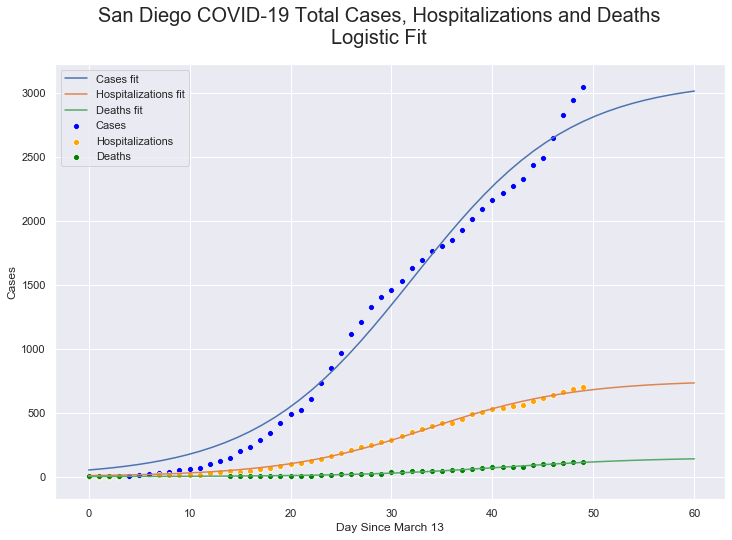

In [7]:


def tc_plot(ax, fit_func):

    t = df.dropna(subset=['day','cases','hosp', 'deaths']).copy()

    x = np.linspace(0,60)

    popt, pcov = curve_fit(fit_func, t.day, t.cases, p0=fit_func.popt, absolute_sigma = True)
    fitted = fit_func(x, *popt)
    sns.lineplot(x, fitted, label='Cases fit')
    sns.scatterplot(df.day, df.cases, ax=ax, color='blue', label='Cases')    
    print(f"C Mean={round(popt[0])}, R^2={r2_score(df.cases, fitted[:len(df.cases)])}")

    popt, pcov = curve_fit(fit_func, t.day, t.hosp,popt, absolute_sigma = True)
    fitted = fit_func(x, *popt)
    sns.lineplot(x, fitted, label='Hospitalizations fit')
    sns.scatterplot(df.day, df.hosp,  ax=ax, color='orange', label='Hospitalizations')
    print(f"H Mean={round(popt[0])}, R^2={r2_score(df.hosp.fillna(0), fitted[:len(df.hosp)])}")

    popt, pcov = curve_fit(fit_func, t.day, t.deaths,popt, absolute_sigma = True)
    fitted = fit_func(x, *popt)
    sns.lineplot(x, fitted, label='Deaths fit')
    #sns.lineplot(x=df.day, y=df.deaths_smooth, ax=ax, label='Deaths')   
    sns.scatterplot(t.day, t.deaths+1, ax=ax, color='green', label='Deaths')
    print(f"D Mean={round(popt[0])}, R^2={r2_score(df.deaths.fillna(0), fitted[:len(df.deaths)])}")

    
fig, ax = plt.subplots(figsize=(12,8))   
tc_plot(ax, func_logistic)
ax.set_ylabel('Cases')
ax.set_xlabel('Day Since March 13')
fig.suptitle("San Diego COVID-19 Total Cases, Hospitalizations and Deaths\nLogistic Fit", fontsize=20);

C Mean=32.0, R^2=0.820534277378995
H Mean=34.0, R^2=0.7950181001948741
D Mean=41.0, R^2=0.5276993385764301


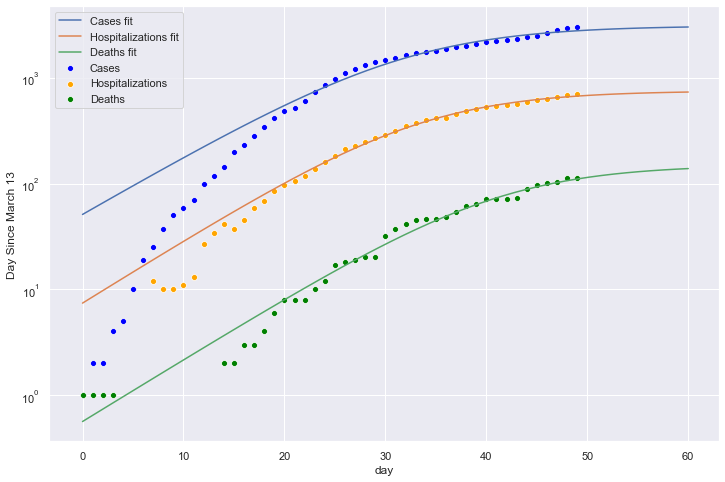

In [8]:
fig, ax = plt.subplots(figsize=(12,8))

tc_plot(ax, func_logistic)

plt.yscale('log')

ax.set_ylabel('Cases')
ax.set_ylabel('Day Since March 13');

ValueError: array length 46 does not match index length 50

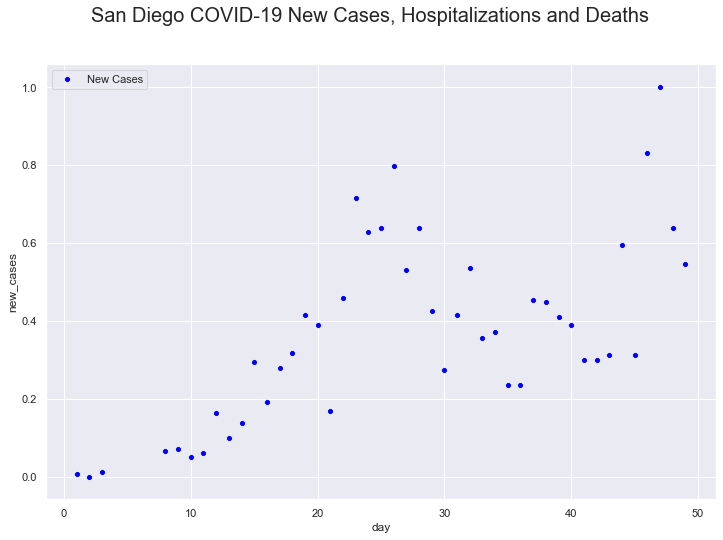

In [9]:
fig, ax = plt.subplots(figsize=(12,8))
fig.suptitle("San Diego COVID-19 New Cases, Hospitalizations and Deaths", fontsize=20);


smoothing = 0.2

fit_func = func_logpdf 

t = df.dropna(subset=['day','new_cases','new_hosp']).copy()

t.new_hosp = t.new_hosp/np.max(t.new_hosp)
t.new_cases = t.new_cases/np.max(t.new_cases)
t.new_deaths = t.new_deaths/np.max(t.new_deaths)

x = np.linspace(0,60)

sns.scatterplot(df.day, t.new_cases, ax=ax, color='blue', label='New Cases')
smoothed = [0]+list(lowess(t.new_cases,  t.day,smoothing)[:,1])
sns.lineplot(df.day, smoothed, label='New Cases Smoothed')

sns.scatterplot(df.day, t.new_hosp, ax=ax, color='orange', label='New Hospitalizations')
smoothed = [0]+list(lowess(t.new_hosp,  t.day, smoothing)[:,1])
sns.lineplot(df.day, smoothed, label='New Hospitalizations Smoothed')


sns.scatterplot(df.day, t.new_deaths, ax=ax, color='green', label='New Deaths')
smoothed = [0]+list(lowess(t.new_deaths,  t.day, smoothing)[:,1])
sns.lineplot(df.day, smoothed, label='New Deaths Smoothed')





In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
fig.suptitle("San Diego COVID-19 New Cases, Hospitalizations and Deaths", fontsize=20);

def nc_plot(df, pct_cases=None, cases_only=False):
    # Fit a normal PDF

    fit_func = func_logpdf or fit_func

    if pct_cases:
        df = df.iloc[:int(pct_cases*len(df))]
    
    t = df.dropna(subset=['day','new_cases','new_hosp']).copy()


    x = np.linspace(0,60)

    sns.scatterplot(df.day, df.new_cases, ax=ax, color='blue', label='New Cases')

    tdl = [0]+list(lowess(df.new_cases,  df.day, 0.2)[:,1])
    sns.lineplot(df.day, tdl, label='New Cases Smoothed')

    popt, pcov = curve_fit(fit_func, t.day, t.new_cases, p0=fit_func.popt, absolute_sigma = True)
    fitted = fit_func(x, *popt)
    sns.lineplot(x, fitted, label='Cases fit')
    
    if not cases_only:
        print(f"C: Mean={round(popt[0])}, R^2={r2_score(df.new_cases[1:], fitted[1:len(df.new_cases)])}")
    
    if not cases_only:
        
        sns.scatterplot(df.day, df.new_hosp,  ax=ax, color='green', label='New Hospitalizations')

        popt, pcov = curve_fit(fit_func, t.day, t.new_hosp,popt, absolute_sigma = True)
        fitted = fit_func(x, *popt)
        sns.lineplot(x, fitted, label='Hospitalizations fit')

        print(f"H: Mean={round(popt[0])}, R^2={r2_score(df.new_hosp[1:], fitted[1:len(df.new_hosp)])}")

        #popt, pcov = curve_fit(func_norm, t.day, t.new_deaths,popt, absolute_sigma = True)
        #sns.lineplot(x, func_norm(x, *popt), label='Deaths fit')  
        #sns.scatterplot(t.day, t.new_deaths, ax=ax, color='green', label='Deaths')
        #print(round(popt[0]))

        
nc_plot(df,1, cases_only=False)


In [ ]:

def ani_nc_plot(ax, df, i, last):
    # Fit a normal PDF

    fit_func = func_logpdf or fit_func

    df = df.iloc[:i]
    
    t = df.dropna(subset=['day','new_cases','new_hosp']).copy()

    x = np.linspace(0,60)

    p1 = sns.scatterplot(df.day, df.new_cases, ax=ax, color='blue')

    tdl = lowess(df.new_cases,  df.day, 0.4)[:,1]
    p2 = sns.lineplot(df.day[:-1], tdl, ax=ax, color='blue')

    popt, pcov = curve_fit(fit_func, t.day, t.new_cases, p0=fit_func.popt, absolute_sigma = True)
    fitted = fit_func(x, *popt)
    
    try:
        d = abs(np.max(fitted) - np.max(last))
    except:
        d = 0
    
    # When the distribution is absurd, use the previous one
    if d > 30:
        dist = last
    else:
        dist = fitted
   
    p3 = sns.lineplot(x, dist, ax=ax, color='orange')

    #ax.legend(p1,['New Cases'])
    
    return fittted

from celluloid import Camera
fig, ax = plt.subplots(figsize=(12,8))
fig.suptitle("San Diego COVID-19 New Cases, Hospitalizations and Deaths\nAnimated by Day", fontsize=20);
camera = Camera(fig)

last = None

for i in range(5, len(df), 1):
    try:
        last = ani_nc_plot(ax, df,i, last)
        #ani_nc_plot(ax, df,i)
        #ani_nc_plot(ax, df,i)
    except:
        
        pass
    camera.snap()

from IPython.display import HTML
animation = camera.animate(interval=200, blit=True)
#HTML(animation.to_html5_video())
#animation.save('celluloid_legends.gif', writer = 'ffmpeg')

In [ ]:


def plot_gr(df, col):

    x = df.day.values.reshape(len(df), 1)[-14:]
    y = df[col].values.reshape(len(df), 1)[-14:]

    regr = linear_model.LinearRegression()
    regr.fit(x, y)

    fig, ax = plt.subplots(figsize=(12,8))
    fig.suptitle('Instantaneous Growth Rate in Confirmed Cases\nIn San Diego Cunty',fontsize=20)

    sns.regplot(ax=ax, x='day',y=col, data=df, lowess=True, label = 'Growth rate')

    ax.plot(x, regr.predict(x), color='red', linewidth=3, label = 'Trajectory of last 10 days')

    ax.set_xlabel('Days Since 13 March', fontsize=18)
    ax.set_ylabel('Rate of Growth', fontsize=18)

   
    plt.gcf().text(.65,0, f"Source data : County of San Diego", fontsize=14) 
    ax.legend(loc='upper left');
    plt.show()

    print('Coefficients:', regr.coef_, regr.intercept_)

    m = regr.coef_[0][0]
    b = regr.intercept_[0]

    
    
    print(f"Zero growth at {-b/m} days")

plot_gr(df.dropna(subset=['cases_rate']), 'cases_rate')
    

In [ ]:
pkg = mp.open_package('http://library.metatab.org/covidtracking.com-covid19-3.1.18.csv')
states = pkg.resource('states').read_csv(parse_dates=True)
ca = states[states.state == 'CA'].copy()
ca['date'] = pd.to_datetime(ca.date, format="%Y%m%d")
ca['day'] = (ca.date - ca.date.min()).dt.days


In [ ]:
pkg = mp.open_package('http://library.metatab.org/healthdata.org-hospitalizations-1.1.0.csv')
ihme = pkg.resource('hospitalizations').read_csv(parse_dates=True)


In [ ]:
ihme['date'] = pd.to_datetime(ihme.date)
ihme['day'] = (ihme.date - ca.date.min()).dt.days

t = ihme[ihme.location_name == 'California'].copy()

fig, ax = plt.subplots(figsize=(12,8))

f = func_erf

popt, pcov = curve_fit(f, t.day, t.deaths_mean.cumsum(), p0=f.popt)

cat = ca.dropna(subset=['date','death'])

popt2, pcov = curve_fit(f, cat.day, cat.death, p0=popt)

ax.plot(t.day, t.deaths_mean.cumsum(), label="IHME Death Projection") # Blue line, CA deaths estimate from IHME
sns.scatterplot(ca.day, ca.death, ax=ax, label="Historic CA Deaths") # Actual death points for CA
ax.plot(t.day, f(t.day, *popt), label="erf fit to IHME projections") # Orange curve fit to IHME estimate
ax.plot(t.day, f(t.day, *popt2), label="erf fit to actual deaths") # Curve fit to points

#ax.set_xlim(0,100)
#ax.set_xlim(0,50)
#ax.set_ylim(0,1000)

ax.legend(loc='upper left');

ax.set_xlabel('Days Past 13 March 2020', fontsize=14)
ax.set_ylabel('Cumulative Deaths', fontsize=14)

fig.suptitle("California COVID-19 Deaths and IHME Projections", fontsize=20);

In [ ]:
pkg = mp.open_package('http://library.metatab.org/healthdata.org-hospitalizations-1.1.1.csv')
ihme = pkg.resource('hospitalizations').dataframe()
ihme['date'] = pd.to_datetime(ihme.date)
ihme['day'] = (ihme.date - ca.date.min()).dt.days

ihme1 = ihme[ihme.location_name == 'California'].copy()

pkg = mp.open_package('http://library.metatab.org/healthdata.org-hospitalizations-1.1.0.csv')
ihme = pkg.resource('hospitalizations').dataframe()
ihme['date'] = pd.to_datetime(ihme.date)
ihme['day'] = (ihme.date - ca.date.min()).dt.days

ihme2 = ihme[ihme.location_name == 'California'].copy()

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(ihme1.date, ihme1.deaths_mean, label="IHME Deaths, 1 April")
ax.plot(ihme2.date, ihme2.deaths_mean, label="IHME Deaths, 15 April")
fig.suptitle("IHME Death Projections For California\n1 April 2020 and 14 April 2020", fontsize=20);
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Deaths Per Day', fontsize=14)
ax.legend(loc='upper left');

In [ ]:
sns.regplot(ca.day, np.log(ca.positive))

x = ca.day.values.reshape(len(ca), 1)
y = np.log(ca.positive).values.reshape(len(ca), 1)

regr = linear_model.LinearRegression()
regr.fit(x, y)

print('Coefficients:', regr.coef_, regr.intercept_)
print("Correlation:", ca.day.corr(np.log(ca.positive)))

m = regr.coef_[0][0]
b = regr.intercept_[0]


In [ ]:
# 